In [1]:
import os, sys

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from sklearn.utils.extmath import row_norms
from sklearn.metrics.pairwise import _euclidean_distances


project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

from yace.run_worker import JobInfo

In [2]:
def get_raw_results(file_paths):
    data_frames = []
    for index, job_info_path in enumerate(file_paths):
        job_info = JobInfo.load_json(job_info_path)
        experiment_type = job_info.command_params["experiment-type"]
        working_dir = job_info_path.parent
        duration_secs = int((job_info.completed_at - job_info.started_at).total_seconds())
        
        distortions_paths = list(working_dir.glob("distortions*.feather"))
        if len(distortions_paths) == 0:
            continue

        df_perf_data = pd.concat([
            pd.read_feather(file_path)
            for file_path in distortions_paths
        ])
        df_perf_data["experiment_id"] = working_dir.name
        df_perf_data["experiment_type"] = experiment_type
        df_perf_data["running_time_secs"] = duration_secs
        
        for param, val in job_info.experiment_params.items():
            df_perf_data[f"{param}"] = val
        
        data_frames.append(df_perf_data)
    df_data = pd.concat(data_frames)
    return df_data

def add_combined_mean_std(df: pd.DataFrame, attr: str):
    def combiner(row) -> str:
        mean = row[f"{attr}_mean"]
        std =  row[f"{attr}_std"]
        return f"{mean:0.4f} ({std:0.5f})"
    df[f"{attr}_mean_std"] = df.apply(lambda x: combiner(x), axis=1)


In [3]:
data_results_dir = Path("../data/experiments-skadi/rw/")

In [4]:
job_info_paths = list(data_results_dir.glob("**/job-info.json"))

In [5]:
df_raw_results = get_raw_results(job_info_paths)

In [6]:
grouping_cols = ["data_set", "k", "algorithm_name", "coreset_size", "solution_type"]
aggregation_spec = dict(
    distortion_mean=("distortion", np.mean),
    distortion_std=("distortion", np.std),
    n_solutions=("distortion", "count")
)
df_grouped = df_raw_results.groupby(grouping_cols).agg(**aggregation_spec).reset_index()
df_grouped

,data_set,k,algorithm_name,coreset_size,solution_type,distortion_mean,distortion_std,n_solutions
0,census,10,sensitivity-sampling,2000,kmeansplusplus,1.022100,0.009673,100
1,census,10,uniform-sampling,2000,kmeansplusplus,1.017269,0.012684,100
2,census,20,sensitivity-sampling,4000,kmeansplusplus,1.044456,0.015556,100
3,census,20,uniform-sampling,4000,kmeansplusplus,1.012051,0.009018,100
4,census,30,sensitivity-sampling,6000,kmeansplusplus,1.024556,0.006936,100
5,census,30,uniform-sampling,6000,kmeansplusplus,1.019629,0.015216,100
6,census,40,sensitivity-sampling,8000,kmeansplusplus,1.035501,0.011662,100
7,census,40,uniform-sampling,8000,kmeansplusplus,1.011056,0.006609,100
8,census,50,sensitivity-sampling,10000,kmeansplusplus,1.029280,0.008884,100
9,census,50,uniform-sampling,10000,kmeansplusplus,1.015973,0.004610,100


In [7]:
pd.pivot(data=df_grouped, index=["data_set", "k"], columns=["algorithm_name"], values="distortion_mean")

algorithm_name  sensitivity-sampling  uniform-sampling
data_set  k                                           
census    10                1.022100          1.017269
          20                1.044456          1.012051
          30                1.024556          1.019629
          40                1.035501          1.011056
          50                1.029280          1.015973
covertype 10                1.034062          1.027080
          20                1.036524          1.015852
          30                1.031120          1.013789
          40                1.033366          1.010638
          50                1.037676          1.009126
tower     20                1.047558          1.015670
          40                1.044472          1.015734
          60                1.038101          1.023700
          80                1.042270          1.024316
          100               1.042459          1.024803

In [8]:
colors = sns.color_palette("tab10")
colors = sns.color_palette("bright")
algorithms = np.sort(df_raw_results.algorithm_name.unique())[::-1]
algorithm_colors = {algo: colors[i] for i, algo in enumerate(algorithms)}
df_raw_results["k_formatted"] = "$k$=" + df_raw_results["k"].astype(str)
df_grouped["k_formatted"] = "$k$=" + df_grouped["k"].astype(str)

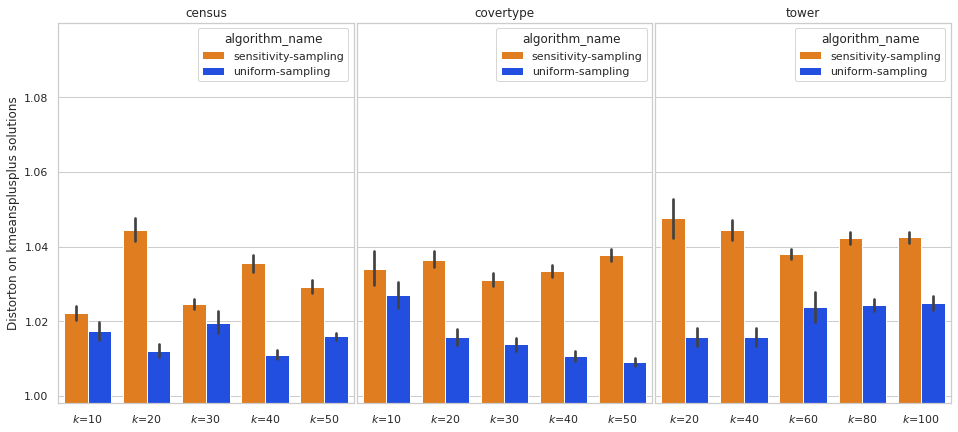

In [9]:
solution_types = df_raw_results["solution_type"].unique()
data_sets = np.sort(df_raw_results["data_set"].unique())
n_rows = len(solution_types)
n_cols = len(data_sets)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True, figsize=(16, 7))

for i, solution_type in enumerate(solution_types):
    for j, data_set in enumerate(data_sets):
        ax = axes[j] # axes[i,j]
        f1 = df_raw_results["solution_type"] == solution_type
        f2 = df_raw_results["data_set"] == data_set
        df_filtered = df_raw_results[f1&f2].copy()
        df_filtered.sort_values(by=["k", "algorithm_name"], inplace=True)
        sns.barplot(data=df_filtered, x="k_formatted", y="distortion", hue="algorithm_name", ax=ax, palette=algorithm_colors)
        ax.set_ylim(bottom=0.998)
        ax.set_title(f"{data_set}")
        ax.set_ylabel(f"Distorton on {solution_type} solutions")
        ax.set_xlabel("")
        if j > 0:
            ax.set_ylabel("")            
        if i == 0:
            ax.set_xlabel("")
fig.subplots_adjust(wspace=0.01)
#fig.savefig("distortions-real-world-v1.pdf", )